<a href="https://colab.research.google.com/github/gokulanv/ToyFederatedLearning/blob/master/TensorFlow/Federated/Genki4k_TFFederated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet --upgrade tensorflow_federated

%load_ext tensorboard

     |████████████████████████████████| 460kB 6.8MB/s 
     |████████████████████████████████| 174kB 24.0MB/s 
     |████████████████████████████████| 296kB 42.3MB/s 
     |████████████████████████████████| 92kB 9.6MB/s 
     |████████████████████████████████| 1.0MB 36.9MB/s 


In [2]:
import collections
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow import reshape, nest, config
from tensorflow.keras import losses, metrics, optimizers
import tensorflow_federated as tff
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


np.random.seed(0)

tff.federated_computation(lambda: 'hi')()

b'hi'

In [0]:
def plot_graph(X, y, format = '-', label=''):
    plt.plot(X, y, format, label=label)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
_URL = 'https://inc.ucsd.edu/mplab/wordpress/wp-content/uploads/genki4k.tar'

path_to_zip = tf.keras.utils.get_file('genki4k.tar', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'genki4k')

29261824/29255680 [==============================] - 2s 0us/step


In [0]:
labels = list([])

text_file = open(os.path.join(os.path.dirname(path_to_zip), 'labels.txt'), "r")
lines = text_file.read().split('\n')
for line in lines[:4000]:
    labels.append(int(line.split()[0]))

In [0]:
data = list([])

for filename in sorted(glob.glob(os.path.join(os.path.dirname(path_to_zip), "files/*"))):
    data.append(os.path.join(os.path.dirname(path_to_zip), "files/", filename))

In [0]:
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [192, 178])
    return image.numpy()

imgs = []
erratic_files = []
for i,filename in enumerate(data):
    img = np.array(parse_image(filename))
    if img.shape[2] == 3:
        imgs.append(img)
    else:
        erratic_files.append(i)


imgs = np.asarray(imgs)
data = imgs
labels = np.asarray(labels)[:, None]

In [8]:
ix = 0
for r in erratic_files:
    r -= ix
    labels = np.delete(labels, r, 0)
    ix += 1
labels.shape, data.shape

((3998, 1), (3998, 192, 178, 3))

In [9]:
len(labels), len(data), labels.shape, data.shape
from sklearn.utils import shuffle
X, Y = shuffle(data, labels, random_state=0)
X.shape, Y.shape

((3998, 192, 178, 3), (3998, 1))

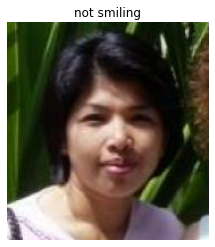

In [10]:
def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title('smiling' if label[0] == 1 else 'not smiling')
  plt.axis('off')

idx = 1149
show(X[idx], Y[idx])

In [0]:
split_index = 3500

x_train, y_train = (X[:split_index], Y[:split_index])
x_test, y_test = (X[split_index:], Y[split_index:])

In [12]:
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.int32)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.int32)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3500, 192, 178, 3), (3500, 1), (498, 192, 178, 3), (498, 1))

In [0]:
total_train_imgs = len(x_train)
federated_clients_dataset_accum = collections.OrderedDict()

NO_OF_CLIENTS = 10
CLIENT_DATA_LEN = total_train_imgs//10

for i in range(NO_OF_CLIENTS):
    client_id = 'client_' + str(i)

    start = i * CLIENT_DATA_LEN
    end = (i + 1) * CLIENT_DATA_LEN

    data = collections.OrderedDict((('labels', y_train[start:end]), ('images', x_train[start:end])))
    federated_clients_dataset_accum[client_id] = data

genki_train = tff.simulation.FromTensorSlicesClientData(federated_clients_dataset_accum)

In [14]:
genki_train.element_type_structure

OrderedDict([('labels', TensorSpec(shape=(1,), dtype=tf.int32, name=None)),
             ('images',
              TensorSpec(shape=(192, 178, 3), dtype=tf.float32, name=None))])

In [15]:
sample_dataset = genki_train.create_tf_dataset_for_client(genki_train.client_ids[0])
element = next(iter(sample_dataset))
element['labels'].numpy()

array([0], dtype=int32)

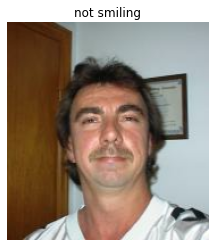

In [16]:
show(element['images'].numpy(), element['labels'].numpy())

In [0]:
NO_OF_CLIENTS = 10
EPOCHS = 1
BATCH_SIZE = 64
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

    def batch_format_fn(element):
        return collections.OrderedDict(
            x = tf.reshape(element['images'], [-1, x_train.shape[1], x_train.shape[2], x_train.shape[3]]),
            y = tf.reshape(element['labels'], [-1, 1])
        )

    return dataset.repeat(EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).map(
        batch_format_fn).prefetch(PREFETCH_BUFFER)


In [18]:
preprocessed_sample_dataset = preprocess(sample_dataset)
tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_sample_dataset)))

OrderedDict([('x', array([[[[0.30981496, 0.3176581 , 0.3058934 ],
                       [0.3137916 , 0.32163474, 0.30987003],
                       [0.32156864, 0.32941177, 0.31764707],
                       ...,
                       [0.35250077, 0.44683865, 0.11737181],
                       [0.3529412 , 0.44705886, 0.11764707],
                       [0.35685176, 0.45096943, 0.12155762]],
              
                      [[0.31764707, 0.3254902 , 0.3137255 ],
                       [0.31761402, 0.32545716, 0.31369245],
                       [0.31367043, 0.32151356, 0.30974886],
                       ...,
                       [0.31345025, 0.41165465, 0.08218779],
                       [0.31761405, 0.41176474, 0.08235294],
                       [0.32155764, 0.4156753 , 0.0862635 ]],
              
                      [[0.32936773, 0.33721086, 0.32544616],
                       [0.31356028, 0.3214034 , 0.3096387 ],
                       [0.29406258, 0.30190572, 0.290

In [19]:
def make_federated_data(client_data, client_ids):
    return [
        preprocess(client_data.create_tf_dataset_for_client(x))
        for x in client_ids
    ]

federated_train_data = make_federated_data(genki_train, genki_train.client_ids)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 192, 178, 3)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [0]:
def create_keras_model():
    model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(192, 178 ,3)),
        MaxPooling2D(),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1)
    ])
    return model

In [0]:
def model_fn():
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(keras_model=keras_model,
                                         input_spec=preprocessed_sample_dataset.element_spec,
                                         loss=tf.keras.losses.BinaryCrossentropy(),
                                         metrics=[tf.keras.metrics.BinaryAccuracy()]
                                        )

In [22]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn = model_fn,
    client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate=0.1),
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [23]:
state = iterative_process.initialize()
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=<binary_accuracy=0.524571418762207,loss=7.101083755493164>


In [26]:
NUM_ROUNDS = 11

tff_train_acc = []
tff_val_acc = []
tff_train_loss = []
tff_val_loss = []

for round_num in range(2, NUM_ROUNDS):
    state, tff_metrics = iterative_process.next(state, federated_train_data)
    print('round {:2d}, metrics={}'.format(round_num, tff_metrics))

    eval_model = create_keras_model()
    eval_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                       loss=tf.keras.losses.BinaryCrossentropy(),
                       metrics=[tf.keras.metrics.BinaryAccuracy()])

    tff.learning.assign_weights_to_keras_model(eval_model, state.model)

    ev_result = eval_model.evaluate(x_test, y_test, verbose=0)
    print('round {:2d}, metrics={}'.format(round_num, tff_metrics))
    print(f"Eval loss : {ev_result[0]} and Eval accuracy : {ev_result[1]}")
    tff_train_acc.append(float(tff_metrics.binary_accuracy))
    tff_val_acc.append(ev_result[1])
    tff_train_loss.append(float(tff_metrics.loss))
    tff_val_loss.append(ev_result[0])

metric_collection = {"binary_accuracy": tff_train_acc,
                     "val_binary_accuracy": tff_val_acc,
                     "loss": tff_train_loss,
                     "val_loss": tff_val_loss}


round  2, metrics=<binary_accuracy=0.4734285771846771,loss=7.565464496612549>
round  2, metrics=<binary_accuracy=0.4734285771846771,loss=7.565464496612549>
Eval loss : 8.610713958740234 and Eval accuracy : 0.4417670667171478
round  3, metrics=<binary_accuracy=0.46399998664855957,loss=8.210233688354492>
round  3, metrics=<binary_accuracy=0.46399998664855957,loss=8.210233688354492>
Eval loss : 8.570904731750488 and Eval accuracy : 0.4417670667171478
round  4, metrics=<binary_accuracy=0.4668571352958679,loss=7.641722202301025>
round  4, metrics=<binary_accuracy=0.4668571352958679,loss=7.641722202301025>
Eval loss : 7.76353645324707 and Eval accuracy : 0.4417670667171478
round  5, metrics=<binary_accuracy=0.5139999985694885,loss=5.688652515411377>
round  5, metrics=<binary_accuracy=0.5139999985694885,loss=5.688652515411377>
Eval loss : 0.8736492395401001 and Eval accuracy : 0.4417670667171478
round  6, metrics=<binary_accuracy=0.4957142770290375,loss=3.2651240825653076>
round  6, metrics=<

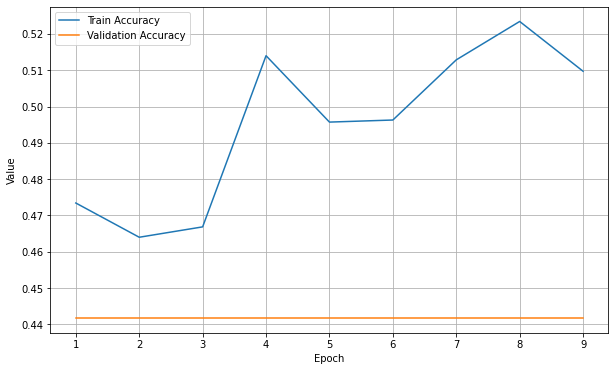

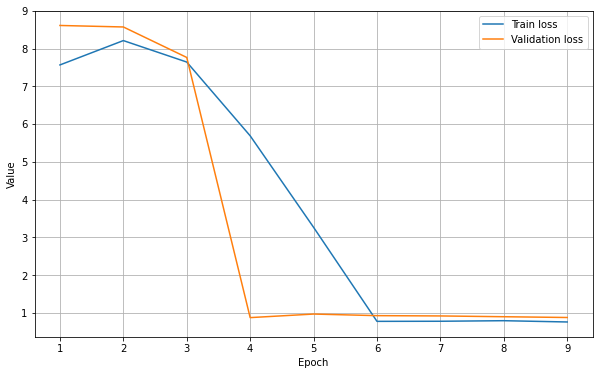

In [35]:
fig = plt.figure(figsize=(10, 6))
plot_graph(list(range(1, 10)), tff_train_acc, label='Train Accuracy')
plot_graph(list(range(1, 10)), tff_val_acc, label='Validation Accuracy')
plt.legend()
# plt.savefig(output_dir / "federated_model_Accuracy.png")

plt.figure(figsize=(10, 6))
plot_graph(list(range(1, 10)), tff_train_loss, label='Train loss')
plot_graph(list(range(1, 10)), tff_val_loss, label='Validation loss')
plt.legend()
# plt.savefig(output_dir / "federated_model_loss.png")